# <font style="color:blue">Table of Content</font>

- [Step 1: Understand Your Problem](#step1)
- [Step 2: Get the Data](#step2)
- [Step 3. Data Preparation](#step3)
- [Step 4: Train a Simple Model](#step4)
- [Step 5: Sample Prediction](#step5)
- [Step 6. Display Mistakes](#step6)

# <font style="color:blue">Project 1 - Part 2: Train an Image Classifier From Scratch</font>
As discussed in the previous notebook, the steps for training Neural Networks are:

- Step 1 - Understand your problem
- Step 2A - Get the data
- Step 2B - Explore and understand your data
- Step 2C - Create a sample data from the dataset
- Step 3 - Data preparation
- Step 4 - Train a simple model on sample data and check the pipeline before proceeding to train the full network
- Step 5 - Train on full data
- Step 6 - Improve your model

You have already been through Steps `1-4` in the previous notebook. Use them here as well.

Here, you will implement Steps `5` & `6` from scratch. Design a model that achieves `>=85%` validation accuracy on the given dataset.

There are 70 points for this notebook. The sections which carry marks are in Red.

There are **70 points** for this notebook. <font style="color:red">The sections which carry marks are in Red.</font>

For GPU compute you can use Kaggle Kernels, Google Colab or any other service of your choice.

After completing the assignment, upload and submit it on the portal for feedback.

<font style="color:red">Use the full data to train the network. You need to achieve 85% accuracy for validation data to successfully complete this assignment.</font>


<font style="color:red">Just remember to build your own model, not use any pre-trained models/weights.</font>


Upon completing the assignment, <font style="color:red">upload the notebook and the models folder on the portal for  feedback.</font>

# <font style="color:blue">Step 1: Understand Your problem </font><a name="step1"></a>
Already covered in the previous notebook.

# <font style="color:blue">Step 2: Get the Data </font><a name="step2"></a>

Already covered in the previous notebook.

In [1]:
#!wget "https://www.dropbox.com/sh/n5nya3g3airlub6/AACi7vaUjdTA0t2j_iKWgp4Ra?dl=1" -O data.zip

### <font style="color:green">Extract the Data</font>

In [2]:
#!unzip -q data.zip

In [3]:
data_path_prefix = "../../../../data/cat_dog_panda_kaggle/" 
!tree -d ./cat-dog-panda

./cat-dog-panda  [error opening dir]

0 directories


# <font style="color:blue">Step 3. Data Preparation</font><a name="step3"></a>
Already covered in the previous notebook.

## <font style="color:blue">3.1. Import Libraries </font>

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [6]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

from torch.optim import lr_scheduler

### <font style="color:green">3.2.1. Compulsary Preprocessing Transforms</font>

In [7]:
def image_preprocess_transforms():
    
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
        ])
    
    return preprocess

### <font style="color:green">3.2.2. Common Image Transforms</font>

In [8]:
def image_common_transforms(mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms()
    
    common_transforms = transforms.Compose([
        preprocess,
        transforms.Normalize(mean, std)
    ])
    
    return common_transforms
    

### <font style="color:green">3.2.3. Mean and STD</font>

In [9]:
def get_mean_std(data_root, num_workers=4):
    
    transform = image_preprocess_transforms()
    
    loader = data_loader(data_root, transform)
    
    batch_mean = torch.zeros(3)
    batch_mean_sqrd = torch.zeros(3)
    
    for batch_data, _ in loader:
        batch_mean += batch_data.mean(dim=(0, 2, 3)) # E[batch_i] 
        batch_mean_sqrd += (batch_data ** 2).mean(dim=(0, 2, 3)) #  E[batch_i**2]
    
    # E[dataset] = E[E[batch_1], E[batch_2], ...]
    mean = batch_mean / len(loader)
    
    # var[X] = E[X**2] - E[X]**2
    
    # E[X**2] = E[E[batch_1**2], E[batch_2**2], ...]
    # E[X]**2 = E[E[batch_1], E[batch_2], ...] ** 2
    
    var = (batch_mean_sqrd / len(loader)) - (mean ** 2)
        
    std = var ** 0.5
    print('mean: {}, std: {}'.format(mean, std))
    
    return mean, std

## <font style="color:blue">3.3. Data Loaders </font>

### <font style="color:green">3.3.1. Data Loader for Full Data</font>
Data loader for generating batches of data to be used by the training routine

In [10]:
def data_loader(data_root, transform, batch_size=16, shuffle=False, num_workers=2):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)
    
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)
    
    return loader

In [11]:
# def data_loader(data_root, transform, batch_size=8, shuffle=False, num_workers=2, subset_size=0.05):
#     dataset = datasets.ImageFolder(root=data_root, transform=transform)
    
#     data_subset = torch.utils.data.Subset(dataset,np.arange(0,len(dataset),1./subset_size).astype(int))

#     loader = torch.utils.data.DataLoader(data_subset, 
#                                          batch_size=batch_size,
#                                          num_workers=num_workers,
#                                          shuffle=shuffle)
    
#     return loader

## <font style="color:green">3.4. Prepare Data</font>
The main function which uses all the above functions to generate the train and test dataloaders.


In [12]:
def get_data(batch_size, data_root, num_workers=4, data_augmentation=False):
#     YOUR CODE HERE
    train_data_path = os.path.join(data_root, 'training')
    mean, std = get_mean_std(data_root=train_data_path, num_workers=num_workers)
    
    common_transforms = image_common_transforms(mean, std)
        
   
    # if data_augmentation is true 
    # data augmentation implementation
    if data_augmentation:    
        # train_transforms = data_augmentation_preprocess(mean, std)
        train_transforms = transforms.Compose([
            transforms.RandomChoice([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(20, fill=(0,)),
                transforms.RandomCrop(28, padding=4)
            ]),
            common_transforms
   ])
    # else do common transforms
    else:
        train_transforms = common_transforms
        
        
    # train dataloader
    
    train_loader = data_loader(train_data_path, 
                               train_transforms, 
                               batch_size=batch_size, 
                               shuffle=True, 
                               num_workers=num_workers)
    
    # test dataloader
    
    test_data_path = os.path.join(data_root, 'validation')
    
    test_loader = data_loader(test_data_path, 
                              train_transforms, 
                              batch_size=batch_size, 
                              shuffle=False, 
                              num_workers=num_workers)
    
    return train_loader, test_loader

# <font style="color:blue">Step 4: Train Your Model</font><a name="step4"></a>

Now, create the training pipeline, and train your model on the full data.

## <font style="color:red">4.1. Configurations [20 Points]</font>

To achieve good results, change the parameters given in these configurations. Score 20 points for all right choices.

### <font style="color:green">4.1.1. System Configuration</font>

Fix the seed (e.g., `21`) to get a reproducible result. 

In [13]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

### <font style="color:green">4.1.2. Training Configuration</font>

In [14]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 25  
    init_learning_rate: float = 0.001  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = data_path_prefix + "./cat-dog-panda" 
    num_workers: int = 2  
    device: str = 'cuda'  
    


### <font style="color:green">4.1.3. System Setup</font>

In [15]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:blue">4.2. Training Function</font>

You are already familiar with the training function. No changes needed here.

In [16]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

## <font style="color:blue">4.3. Validation Function</font>

In [17]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        with torch.no_grad():
            output = model(data)
        
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    
    return test_loss, accuracy/100.0

## <font style="color:blue">4.4. Save the Model</font>

In [18]:
def save_model(model, device, model_dir=data_path_prefix + 'models', model_file_name='cat_dog_panda_classifier.pt'):
    

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)
    
    if device == 'cuda':
        model.to('cuda')
    
    return

## <font style="color:blue">4.5. Load the Model</font>

In [19]:
def load_model(model, model_dir=data_path_prefix + 'models', model_file_name='cat_dog_panda_classifier.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))
    
    return model

## <font style="color:blue">4.6. Main Function for Training</font>

Note: Before calling the train function, we calculate the validation loss, which we know should be close to $\log(\text{num_classes})$. Also, the accuracy should be close to $\frac{1}{\text{num_classes}}$.

In [20]:
def main(model, optimizer, scheduler=None, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration(), data_augmentation=True):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set,
        data_augmentation=data_augmentation
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # Calculate Initial Test Loss
    init_val_loss, init_val_accuracy = validate(training_configuration, model, test_loader)
    print("Initial Test Loss : {:.6f}, \nInitial Test Accuracy : {:.3f}%\n".format(init_val_loss, 
                                                                                   init_val_accuracy*100))
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                print('Model Improved. Saving the Model...\n')
                save_model(model, device=training_configuration.device)
        
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

## <font style="color:blue">4.7. Plot Loss and Accuracy</font>

In [21]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors, 
                       loss_legend_loc='upper center', acc_legend_loc='upper left', 
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):
    
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])
    
    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))
        
        min_train_loss = train_loss[i].min()
        
        min_val_loss = val_loss[i].min()
        
        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID LOSS ({0:.4})".format(min_val_loss))
        
    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')
        
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])
    
    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))
        
        max_train_acc = train_acc[i].max() 
        
        max_val_acc = val_acc[i].max() 
        
        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID ACC ({0:.4})".format(max_val_acc))
        
    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')
    
    fig.savefig('sample_loss_acc_plot.png')
    plt.show()
    
    return   

## <font style="color:red">4.8. Define Model [20 Points]</font>

Next, define the CNN model. Keep iterating. Do this by training various models. Just ,change the :
    
- number of layers
- parameters inside the layers
- different types of layers

In [22]:
# class MyModel(nn.Module):
# #     YOUR CODE HERE
#     def __init__(self):
#         super().__init__()

#         # convolution layers
#         self._body = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2),
            
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2),
#         )

        
#         # Fully connected layers
#         self._head = nn.Sequential(
#             nn.Linear(in_features=64*52*52, out_features=1024), 
#             nn.ReLU(inplace=True),
            
#             nn.Linear(in_features=1024, out_features=3)
            
#         )
    
#     def forward(self, x):
        
#         # apply feature extractor
#         x = self._body(x)
#         # flatten the output of conv layers
#         # dimension should be batch_size * number_of weight_in_last conv_layer
#         x = x.view(x.size()[0], -1)
#         # apply classification head
#         x = self._head(x)
        
        
#         return x

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=64 * 52 * 52, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=3)

    def forward(self, x):
        # Convolutional and pooling layers with ReLU activation
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)  # Reshape to (batch_size, num_features)
        
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

## <font style="color:red">4.9. Training [20 Points]</font>

Experiment with:

- Optimizers and learning rate schedulers \[You can  get good results even without a learning rate scheduler\]

- Regularization techniques like Data Augmentation, Dropout, BatchNorm

In [24]:
model = MyModel()
print(model)

# get optimizer
train_config = TrainingConfiguration()

### CHANGE HERE ###

# optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr = train_config.init_learning_rate
)

decay_rate = 0.9
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)

MyModel(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=173056, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=3, bias=True)
)


In [ ]:
# train and validate
model, train_loss, train_acc, val_loss, val_acc = main(model, optimizer, scheduler=scheduler, data_augmentation=True)

mean: tensor([0.4610, 0.4347, 0.3897]), std: tensor([0.2734, 0.2641, 0.2616])

Test set: Average loss: 1.1008, Accuracy: 207/600 (34%)

Initial Test Loss : 1.100758, 
Initial Test Accuracy : 34.500%



## <font style="color:blue">4.10. Loss and Accuracy Plot</font>

In [ ]:
plot_loss_accuracy(train_loss=[train_loss], 
                   val_loss=[val_loss], 
                   train_acc=[train_acc], 
                   val_acc=[val_acc], 
                   colors=['blue'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

# <font style="color:blue">Step 5. Sample Prediction</font><a name="step5"></a>

Show some sample predictions.

## <font style="color:blue">5.1. Make Predictions</font>

In [27]:
def prediction(model, device, batch_input):
    
    data = batch_input.to(device)
    
    with torch.no_grad():
        output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

## <font style="color:blue">5.2. Get Predictions on a Batch</font>

In [28]:
def get_sample_prediction(model, data_root, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2
    
    # It is important to do model.eval() before prediction
    model.eval()
    
    # Send model to cpu/cuda according to your system configuration
    model.to(device)

    # transformed data
    test_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(mean, std))
    
    # original image dataset
    test_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms())
    
    data_len = test_dataset.__len__()
    
    interval = int(data_len/batch_size)
    
    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = test_dataset_trans.__getitem__(index)
        img, _ = test_dataset.__getitem__(index)
        
        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)
        
    inputs = torch.stack(inputs)
        
    cls, prob = prediction(model, device, batch_input=inputs)
    
    plt.style.use('default')
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()
    
    
    for i, target in enumerate(targets):
        plt.subplot(3, 5, i+1)
        img = transforms.functional.to_pil_image(imgs[i])
        plt.imshow(img)
        plt.gca().set_title('P:{0}({1:.2}), T:{2}'.format(test_dataset.classes[cls[i]], 
                                                     prob[i], 
                                                     test_dataset.classes[targets[i]]))
    fig.savefig('sample_prediction.png')
    plt.show()
    
    return
        
    

## <font style="color:blue">5.3. Load Model and Run Inference</font>

/tmp/ipykernel_1021623/2230902771.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


mean: tensor([0.4551, 0.4301, 0.3894]), std: tensor([0.2749, 0.2648, 0.2628])


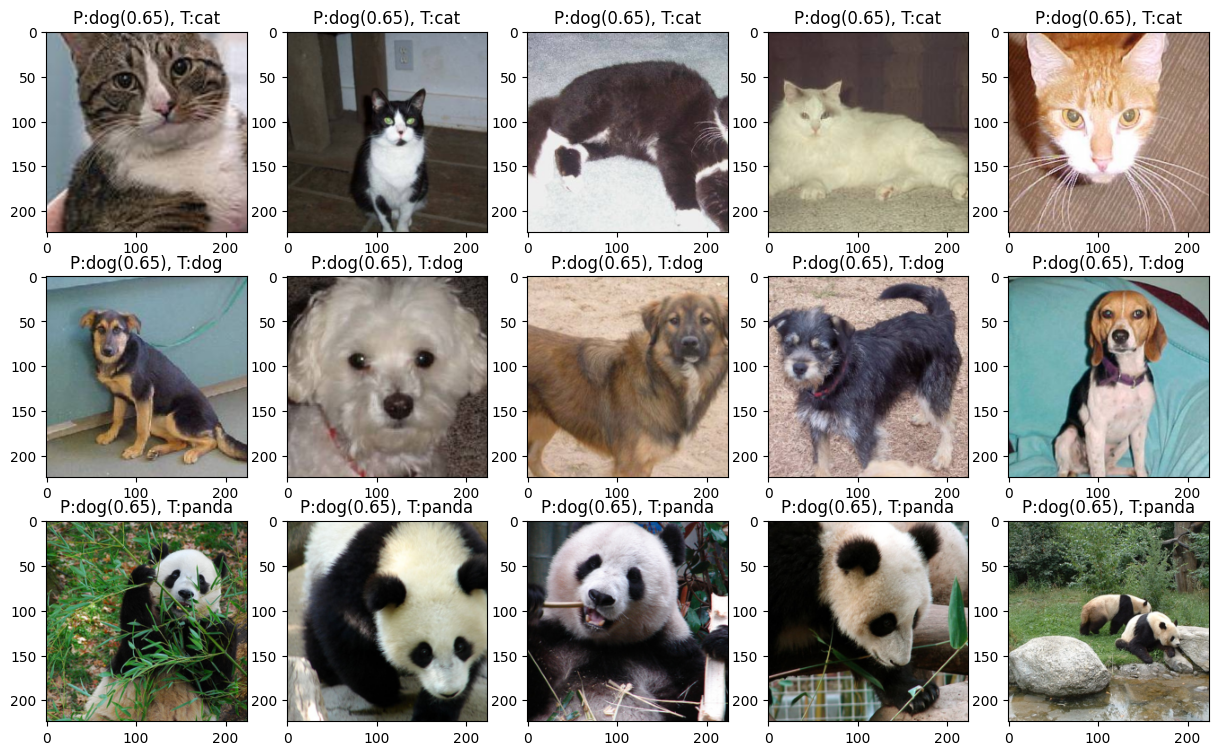

In [29]:
m = MyModel()
m = load_model(m)

train_config = TrainingConfiguration()

test_data_path = os.path.join(train_config.data_root, 'validation')
train_data_path = os.path.join(train_config.data_root, 'training')

mean, std = get_mean_std(train_data_path)

get_sample_prediction(m, test_data_path, mean, std)

# <font style="color:red">Step 6. Display Confusion Matrix [10 Points]</font><a name="step6"></a>

Display the confusion matrix for the above problem(Refer to the earlier lectures on Performance Metrics).


The output should resemble this:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/02/c3_w5_sample_confusion_matrix.png' width=600>


In [30]:
# YOUR CODE HERE
def create_confusion_matrix(model, data_root, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2
    
    # It is important to do model.eval() before prediction
    model.eval()
    
    # Send model to cpu/cuda according to your system configuration
    model.to(device)

    # transformed data
    test_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(mean, std))
    
    # original image dataset
    test_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms())
    
    data_len = test_dataset.__len__()
    
    interval = int(data_len/batch_size)
    
    # imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = test_dataset_trans.__getitem__(index)
        # img, _ = test_dataset.__getitem__(index)
        
        # imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)
        
    inputs = torch.stack(inputs)
        
    cls, prob = prediction(model, device, batch_input=inputs)

    cm = confusion_matrix(targets, cls)

    class_lables = ['cat', 'dog', 'panda']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
              xticklabels=class_lables, yticklabels=class_lables)
    
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()
    
    return

/tmp/ipykernel_1021623/2230902771.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


mean: tensor([0.4551, 0.4301, 0.3894]), std: tensor([0.2749, 0.2648, 0.2628])


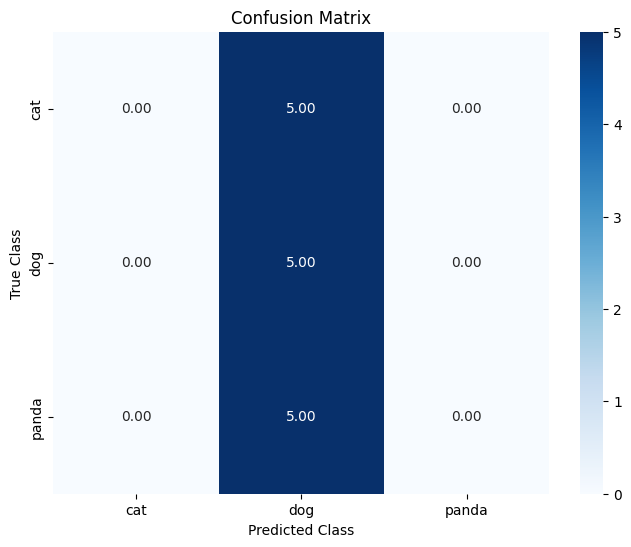

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
m = MyModel()
m = load_model(m)

train_config = TrainingConfiguration()

test_data_path = os.path.join(train_config.data_root, 'validation')
train_data_path = os.path.join(train_config.data_root, 'training')

mean, std = get_mean_std(train_data_path)

create_confusion_matrix(m, test_data_path, mean, std)

Upon completing the assignment,  <font style="color:red">pload the 2 notebooks and the models folder on the portal for feedback.</font>